# MI-FM1：Flow Matching を用いた Multiple Imputation（多重代入）の最小デモ

## 概要
- 目的：欠測補完を「条件付き分布のサンプリング」として扱い，MICE 系（IterativeImputer）と FM を比較する土台を作ります．
- 内容：欠測（MAR）を人工生成し，IterativeImputer と FM による補完サンプルの違いを可視化します．
- 実行：上から順に実行（Run All）してください（学習ループあり）．
- 依存：torch, numpy, scikit-learn, matplotlib（GPU は任意）．
- 出力：補完結果の図・要約．

## 実行メモ
- 乱数性があります（seed を固定したい場合は冒頭セルで設定してください）．
- 実行環境：Python 3 系（推奨：3.10+）．GPU は任意です．


device: cuda
missing rate x3: 0.35933333333333334
step  1000 | loss 1.3847
step  2000 | loss 1.2460
step  3000 | loss 1.2241
step  4000 | loss 1.1601
step  5000 | loss 1.0874
step  6000 | loss 0.9788
Imputation RMSE on missing x3 | MICE: 0.8483 | FM: 0.8481

Regression coefficients (y ~ 1 + Xz1 + Xz2 + Xz3)
MICE beta: [-0.0875  0.7411  0.8172  0.9251]   se: [0.0264 0.0346 0.0285 0.0372]
FM   beta: [-0.092   0.7149  0.8214  0.9789]   se: [0.0256 0.0345 0.0286 0.0383]
True (approx): [0.     0.4971 0.7892 1.4505]


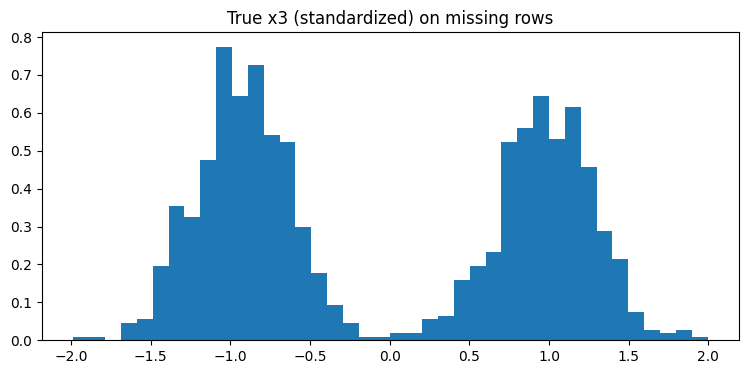

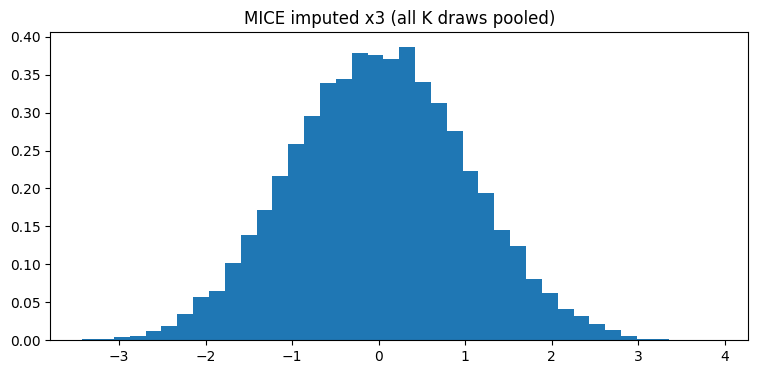

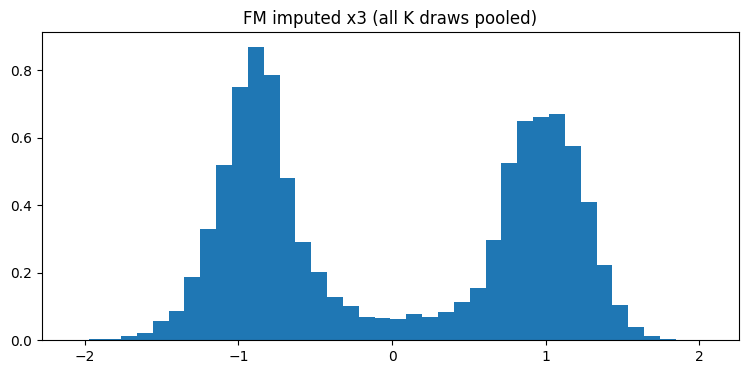

In [1]:
# --- If needed (Colab) ---
# !pip -q install scikit-learn torch

import numpy as np
import math
import torch
import torch.nn as nn
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt

# -----------------------
# 0) utilities
# -----------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ols_with_se(X, y):
    """
    OLS beta_hat and covariance estimate under homoskedasticity.
    X: (n, p) with intercept included if needed
    """
    n, p = X.shape
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    beta = XtX_inv @ (X.T @ y)
    resid = y - X @ beta
    s2 = (resid @ resid) / (n - p)
    V = s2 * XtX_inv
    return beta, V

def rubin_combine(betas, Vs):
    """
    betas: (K, p)
    Vs: (K, p, p)
    """
    K = betas.shape[0]
    beta_bar = betas.mean(axis=0)
    W = Vs.mean(axis=0)
    B = np.cov(betas.T, ddof=1)  # between-imputation
    T = W + (1 + 1/K) * B
    return beta_bar, T, W, B

# -----------------------
# 1) data generating process (nonlinear + multimodal conditional)
# -----------------------
def make_data(n=3000, seed=0):
    rng = np.random.default_rng(seed)
    x1 = rng.normal(0, 1, size=n)
    x2 = np.sin(2 * x1) + 0.35 * rng.normal(0, 1, size=n)

    # bimodal conditional for x3
    p = sigmoid(2.0 * x1)  # mixture weight depends on x1
    comp = rng.uniform(0, 1, size=n) < p
    x3 = np.where(comp,
                  rng.normal( 2.0, 0.6, size=n),
                  rng.normal(-2.0, 0.6, size=n))

    X = np.stack([x1, x2, x3], axis=1)

    # outcome model (linear analysis target)
    beta_true = np.array([0.5, 1.0, 0.7])  # for x1,x2,x3
    y = X @ beta_true + rng.normal(0, 1.0, size=n)

    return X, y, beta_true

# -----------------------
# 2) induce MAR missingness (x3 missing depends on observed x2)
# -----------------------
def make_missing(X, seed=0, miss_rate_target=0.35):
    rng = np.random.default_rng(seed)
    Xmiss = X.copy()

    # MAR: P(M3=1 | X) depends on x2 only
    logits = -0.3 + 1.3 * np.abs(X[:, 1])
    p = sigmoid(logits)

    # scale to hit target rate roughly
    # quick adjustment: shift logits
    shift = 0.0
    for _ in range(20):
        pm = sigmoid(logits + shift)
        rate = pm.mean()
        shift += np.log(miss_rate_target/(1-miss_rate_target)) - np.log(rate/(1-rate))
        if abs(rate - miss_rate_target) < 1e-3:
            break

    pm = sigmoid(logits + shift)
    m3 = rng.uniform(0, 1, size=X.shape[0]) < pm  # True = missing

    Xmiss[m3, 2] = np.nan
    return Xmiss, m3

# -----------------------
# 3) standard MI baseline: MICE (linear Gaussian)
# -----------------------
def mice_impute_many(Xmiss, K=20, seed=0):
    imputations = []
    for k in range(K):
        imp = IterativeImputer(
            estimator=BayesianRidge(),
            sample_posterior=True,
            max_iter=20,
            random_state=seed + 1000 + k
        )
        Xk = imp.fit_transform(Xmiss)
        imputations.append(Xk)
    return np.stack(imputations, axis=0)  # (K,n,d)

# -----------------------
# 4) conditional flow matching imputer
#    - condition: (x_filled, mask) where mask=1 missing
#    - training: self-supervised mask on observed entries; loss only on hidden entries
# -----------------------
class CFMImputer(nn.Module):
    def __init__(self, d, hidden=128):
        super().__init__()
        self.d = d
        self.net = nn.Sequential(
            nn.Linear(1 + d + d, hidden),  # t + x_t + mask
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, d),
        )

    def forward(self, t, x_t, m):
        """
        t: (B,1), x_t: (B,d), m: (B,d)  (m=1 means missing)
        returns v: (B,d)
        """
        z = torch.cat([t, x_t, m], dim=1)
        return self.net(z)

def train_cfm(Xmiss, steps=6000, batch=256, lr=2e-3, p_hide=0.3, seed=0, device="cpu"):
    torch.manual_seed(seed)
    np.random.seed(seed)

    Xnp = Xmiss.copy()
    isnan = np.isnan(Xnp)
    x_filled = np.where(isnan, 0.0, Xnp).astype(np.float32)
    m_base = isnan.astype(np.float32)  # 1 if missing

    x_filled = torch.from_numpy(x_filled).to(device)
    m_base = torch.from_numpy(m_base).to(device)

    n, d = x_filled.shape
    model = CFMImputer(d=d).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # indices with at least 1 observed entry
    ok = (m_base.sum(dim=1) < d).nonzero(as_tuple=True)[0]

    for it in range(steps):
        idx = ok[torch.randint(0, ok.shape[0], (batch,), device=device)]
        x1 = x_filled[idx]               # observed values (missing filled with 0)
        m0 = m_base[idx]                 # original missing mask

        # choose additional "hide mask" only on observed entries
        obs = (1.0 - m0)
        hide = (torch.rand_like(obs) < p_hide) * obs  # hide subset of observed
        m_train = torch.clamp(m0 + hide, 0.0, 1.0)

        # x1_true for hidden entries is available (because hide only on observed)
        # define x0: observed dims clamped, missing dims sampled from N(0,1)
        eps = torch.randn_like(x1)
        x0 = x1 * (1.0 - m_train) + eps * m_train

        # sample t and path (linear interpolation)
        t = torch.rand(batch, 1, device=device)
        x_t = (1.0 - t) * x0 + t * x1

        # target velocity for this path
        u = x1 - x0

        # predict and compute loss only on hide entries (not on originally missing)
        v = model(t, x_t, m_train)

        mask_loss = hide  # only those we intentionally hid
        denom = mask_loss.sum() + 1e-8
        loss = ((v - u) ** 2 * mask_loss).sum() / denom

        opt.zero_grad()
        loss.backward()
        opt.step()

        if (it + 1) % 1000 == 0:
            print(f"step {it+1:5d} | loss {loss.item():.4f}")

    return model

@torch.no_grad()
def cfm_impute(model, Xmiss, K=20, n_steps=50, seed=0, device="cpu"):
    """
    Generate K multiple imputations via ODE integration (Euler).
    """
    torch.manual_seed(seed)
    Xnp = Xmiss.copy()
    isnan = np.isnan(Xnp)
    x_obs = np.where(isnan, 0.0, Xnp).astype(np.float32)
    m = isnan.astype(np.float32)

    x_obs = torch.from_numpy(x_obs).to(device)
    m = torch.from_numpy(m).to(device)
    n, d = x_obs.shape

    outs = []
    dt = 1.0 / n_steps

    for k in range(K):
        # initial x0: observed fixed, missing from N(0,1)
        eps = torch.randn_like(x_obs)
        x = x_obs * (1.0 - m) + eps * m

        # integrate t=0..1
        for s in range(n_steps):
            t = torch.full((n, 1), s * dt, device=device)
            v = model(t, x, m)
            x = x + dt * v * m  # update missing dims only
            x = x * m + x_obs * (1.0 - m)  # clamp observed dims
        outs.append(x.detach().cpu().numpy())

    return np.stack(outs, axis=0)  # (K,n,d)

# -----------------------
# 5) run demo
# -----------------------
def run_demo(seed=0, n=3000, K=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print("device:", device)

    X, y, beta_true = make_data(n=n, seed=seed)
    Xmiss, miss_mask = make_missing(X, seed=seed+1, miss_rate_target=0.35)
    print("missing rate x3:", np.mean(miss_mask))

    # standardize features for learning stability (using complete in this simulation)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-8
    Xz = (X - mu) / sd
    Xmiss_z = (Xmiss - mu) / sd

    # analysis uses standardized X, so adjust true beta accordingly:
    # y = X beta + e = (Xz*sd + mu) beta + e
    # if we regress y on Xz, the coefficient is beta_z = sd * beta
    beta_true_z = sd.flatten() * beta_true

    # 5.1 MICE imputations
    Xmice = mice_impute_many(Xmiss_z, K=K, seed=seed+2)

    # 5.2 Train FM on incomplete data (self-supervised hiding)
    model = train_cfm(Xmiss_z, steps=6000, batch=256, lr=2e-3, p_hide=0.3,
                      seed=seed+3, device=device)

    # 5.3 FM imputations
    Xfm = cfm_impute(model, Xmiss_z, K=K, n_steps=50, seed=seed+4, device=device)

    # -----------------------
    # evaluation: imputation RMSE on truly missing x3 entries
    # -----------------------
    true_x3 = Xz[miss_mask, 2]
    mice_x3 = Xmice[:, miss_mask, 2].mean(axis=0)  # mean imputation for RMSE
    fm_x3   = Xfm[:,   miss_mask, 2].mean(axis=0)

    rmse_mice = np.sqrt(np.mean((mice_x3 - true_x3) ** 2))
    rmse_fm   = np.sqrt(np.mean((fm_x3   - true_x3) ** 2))
    print(f"Imputation RMSE on missing x3 | MICE: {rmse_mice:.4f} | FM: {rmse_fm:.4f}")

    # -----------------------
    # evaluation: MI inference for regression y ~ (1, Xz)
    # -----------------------
    def mi_regression(XK):
        betas = []
        Vs = []
        for k in range(K):
            Xk = XK[k]
            Xdesign = np.column_stack([np.ones(n), Xk])  # intercept
            beta_hat, V_hat = ols_with_se(Xdesign, y)
            betas.append(beta_hat)
            Vs.append(V_hat)
        betas = np.stack(betas, axis=0)
        Vs = np.stack(Vs, axis=0)
        beta_bar, T, W, B = rubin_combine(betas, Vs)
        se = np.sqrt(np.diag(T))
        return beta_bar, se, T

    b_mice, se_mice, Tm = mi_regression(Xmice)
    b_fm,   se_fm,   Tf = mi_regression(Xfm)

    # true for standardized regression:
    beta_true_design = np.concatenate([[0.0], beta_true_z])  # intercept approx 0 in this DGP
    print("\nRegression coefficients (y ~ 1 + Xz1 + Xz2 + Xz3)")
    for name, b, se in [("MICE", b_mice, se_mice), ("FM  ", b_fm, se_fm)]:
        print(f"{name} beta:", np.round(b, 4), "  se:", np.round(se, 4))

    print("True (approx):", np.round(beta_true_design, 4))

    # -----------------------
    # distributional demo: x3 imputations should keep bimodality
    # -----------------------
    plt.figure(figsize=(9,4))
    plt.hist(true_x3, bins=40, density=True)
    plt.title("True x3 (standardized) on missing rows")
    plt.show()

    plt.figure(figsize=(9,4))
    plt.hist(Xmice[:, miss_mask, 2].ravel(), bins=40, density=True)
    plt.title("MICE imputed x3 (all K draws pooled)")
    plt.show()

    plt.figure(figsize=(9,4))
    plt.hist(Xfm[:, miss_mask, 2].ravel(), bins=40, density=True)
    plt.title("FM imputed x3 (all K draws pooled)")
    plt.show()

run_demo(seed=0, n=3000, K=20)
